## Basic Data Preparation

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_style('darkgrid')
pd.set_option('display.float_format', '{:.2f}'.format)

df1 = pd.read_csv('./df1.csv')
df1.head(3)

,ITEM_ID,ITEM_DESCRIPTION,CHANNEL,STORE_ID,PERIOD_ID,SALES_UNITS_EXPANDED,SALES_VOLUME_EXPANDED,SALES_VALUE_EXPANDED
0,1,001_Item,TOTAL_MARKET,31905,70,1,1.00,199.90
1,1,001_Item,TOTAL_MARKET,31905,71,3,3.00,599.70
2,1,001_Item,TOTAL_MARKET,31905,72,1,1.00,199.90


* ITEM ID = уникальный код, связанный с каждым товаром
* ITEM DESCRIPTION = название товара с соответствующим номером
* CHANNEL = рынок, охватываемый базой данных
* STORE ID = уникальный идентификатор магазина
* PERIOD ID = уникальный идентификатор недели с осмысленными значениями: наименьшее значение представляет первую неделю в данных, а наибольшее - последнюю. Каждая последующая итерация с первой недели добавляет одну неделю
* SALES UNITS EXPANDED = количество проданных единиц
* SALES VOLUME EXPANDED = проданный объём
* SALES VALUE EXPANDED = стоимость проданных единиц

1. Убедимся, что данные имеют правильный формат. ITEM ID, STORE ID, PERIOD ID должны быт целыми числами, все столбцы с данными о продажах должны быть числами с плавающей точкой, а остальные столбцы должны быть объектами
2. Преобразование PERIOD ID: самое низкое значение PERIOD ID соответствует 19 неделе 2019 - ого года. Использовать календарь недель
3. Рассчитайте числовое распределение каждого товара (item) по месяцам как Сумму магазинов в которых есть item / Сумму всех магазинов. Предположим, что эти 8 товаров и представляют собой весь рынок. Какое значение распределения 005_Item? В каком месяце оно наибольшее?

In [2]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500185 entries, 0 to 7500184
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ITEM_ID                int64  
 1   ITEM_DESCRIPTION       object 
 2   CHANNEL                object 
 3   STORE_ID               int64  
 4   PERIOD_ID              int64  
 5   SALES_UNITS_EXPANDED   int64  
 6   SALES_VOLUME_EXPANDED  float64
 7   SALES_VALUE_EXPANDED   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 457.8+ MB


Убеждаемся, что переменные ITEM_ID, STORE_ID, PERIOD_ID типа integer. </br> 
По условию задачи, все все sales-columns должны быть типа float, поэтому приведём стобец SALES_UNITS_EXPANDED к нужному формату. </br>
Оставшиеся стобцы, ITEM_DESCRIPTION и CHANNEL, действительно типа object.

In [4]:
df1['SALES_UNITS_EXPANDED'] = df1['SALES_UNITS_EXPANDED'].astype(float)
df1['PERIOD_ID'].min() #10

date_format = '%Y-%W-%w' #формат даты год-неделя-день недели
start_date = datetime.datetime.strptime('2019-18-0', date_format) #в python нумерация начинается с нулевой недели
delta = datetime.timedelta(weeks=1) #одна неделя

#ФУНКЦИЯ ДЕКОДИРОВАНИЯ ДАТЫ
def to_decode_date(encoded_date):
    return start_date + (encoded_date - 10)*delta

df1['PERIOD_ID'] = df1['PERIOD_ID'].apply(to_decode_date)
df1['MONTH'] = df1['PERIOD_ID'].dt.month

df1.ITEM_ID.nunique() #8
df1.STORE_ID.nunique() #32489

monthly_dist = df1.groupby(['ITEM_ID', 'MONTH'])['STORE_ID'].nunique().reset_index()
monthly_dist['NUM_DIST'] = monthly_dist['STORE_ID'] / df1['STORE_ID'].nunique()
monthly_dist.head()

,ITEM_ID,MONTH,STORE_ID,NUM_DIST
0,1,1,31095,0.96
1,1,2,31172,0.96
2,1,3,28841,0.89
3,1,4,28831,0.89
4,1,5,30425,0.94


Построим запрашиваемое распределения доли представленности в магазинах SKU с ITEM_ID = 5.

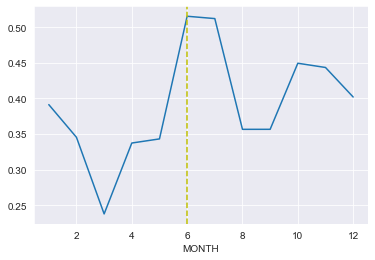

In [11]:
max_index = monthly_dist[monthly_dist.ITEM_ID == 5]['NUM_DIST'].idxmax()
max_month = monthly_dist[monthly_dist.ITEM_ID == 5].loc[max_index,'MONTH']

plt.plot(monthly_dist[monthly_dist.ITEM_ID == 5].MONTH, monthly_dist[monthly_dist.ITEM_ID == 5].NUM_DIST)
plt.axvline(x=max_month, color='y', linestyle='--')
plt.xlabel('MONTH')
plt.show()

In [16]:
min_value = monthly_dist[monthly_dist.ITEM_ID == 5]['NUM_DIST'].min()
round(min_value, 2) #0.24
max_value = monthly_dist[monthly_dist.ITEM_ID == 5]['NUM_DIST'].max()
round(max_value, 2)

0.52

Значение доли представленности в магазинах рассматриваемого ITEM изменяется от 0.24 до 0.52 на рассматриваемом промежутке времени и достигает своего максимального значения в Июне.

## Data Description and Pre-processing

1. Постройте гистограмму для SALES UNITS EXPANDED для каждого товара.
* Какому распределению оно следует?
* Каковы параметры этого распределения?
* Изменится ли ответ, если мы применим логарифмическое преобразование?

<AxesSubplot:title={'center':'SALES_UNITS_EXPANDED'}, xlabel='ITEM_ID'>

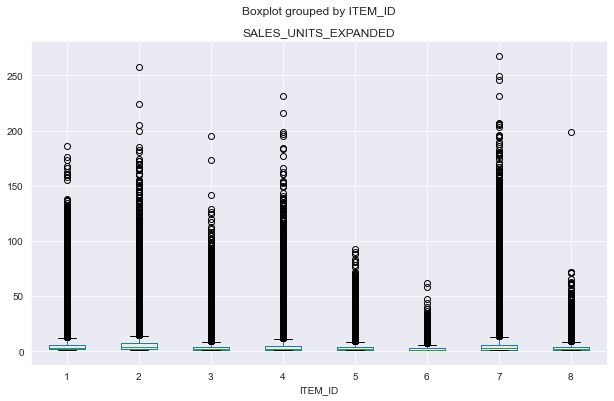

In [17]:
df1.boxplot(column='SALES_UNITS_EXPANDED', by='ITEM_ID', figsize=(10, 6))

Распределение значений SALES_UNITS_EXPANDED соответствует логнормальному распределению, так как имеет смещённую сильно влево медиану и длинный правый хвост. 

In [19]:
median_values = df1.groupby('ITEM_ID')['SALES_UNITS_EXPANDED'].median()
median_values

ITEM_ID
1   3.00
2   4.00
3   2.00
4   2.00
5   2.00
6   1.00
7   3.00
8   2.00
Name: SALES_UNITS_EXPANDED, dtype: float64

In [21]:
quantile_values= df1.groupby('ITEM_ID')['SALES_UNITS_EXPANDED'].quantile([0.25, 0.75])
quantile_values

ITEM_ID      
1        0.25   2.00
         0.75   6.00
2        0.25   2.00
         0.75   7.00
3        0.25   1.00
         0.75   4.00
4        0.25   1.00
         0.75   5.00
5        0.25   1.00
         0.75   4.00
6        0.25   1.00
         0.75   3.00
7        0.25   1.00
         0.75   6.00
8        0.25   1.00
         0.75   4.00
Name: SALES_UNITS_EXPANDED, dtype: float64

**Ответ:** </br>
Логарифмическое преобразование может помочь сгладить смещение влево и уменьшить разброс данных.

2. Создайте переменную с именем ACTUAL PRICE. Это будет ассоциированная цена за единицу для определённого SKU в заданной неделе товара. Используйте доступные столбцы, чтобы получить это значение.
3. Постройте на одном графике SALES UNITS EXPANDED и ACTUAL PRICE с PERIOD ID на оси x.
* Замечаете ли вы сезонные паттерны? Они похожи для всех товаров?
* Можно ли сделать вывод, что снижение цены приводит к увеличению продаж по этому графику? Почему да/нет? Теперь постройте второй график с SALES UNITS EXPADED и количеством магазинов с PERIOD ID на оси х. Подтверждает ли это ваше предыдущее заключение?
4. Обсудите как бы вы подошли к созданию переменных REGULAR PRICE и PROMO.
* REGULAR PRICE = цена за единицу в отсутствие любой акции
* PROMO = бинарная переменная, указывающая, была ли проведена акционная цена для каждого наблюдения.

In [5]:
df1['ACTUAL_PRICE'] = df1['SALES_VALUE_EXPANDED'] / df1['SALES_UNITS_EXPANDED']

#СТРОИМ ПРИЗНАК МЕСЯЦ-ГОД
df1['MONTH_YEAR'] = df1['PERIOD_ID'].dt.strftime('%B-%Y')
df1['MONTH_YEAR'] = pd.to_datetime(df1['MONTH_YEAR'], format='%B-%Y')

sales_data = df1.groupby(['MONTH_YEAR', 'ITEM_ID'])['SALES_UNITS_EXPANDED'].sum().reset_index()
sales_data.head(3)

,MONTH_YEAR,ITEM_ID,SALES_UNITS_EXPANDED
0,2019-05-01,1,335884.00
1,2019-05-01,3,160105.00
2,2019-05-01,4,149143.00


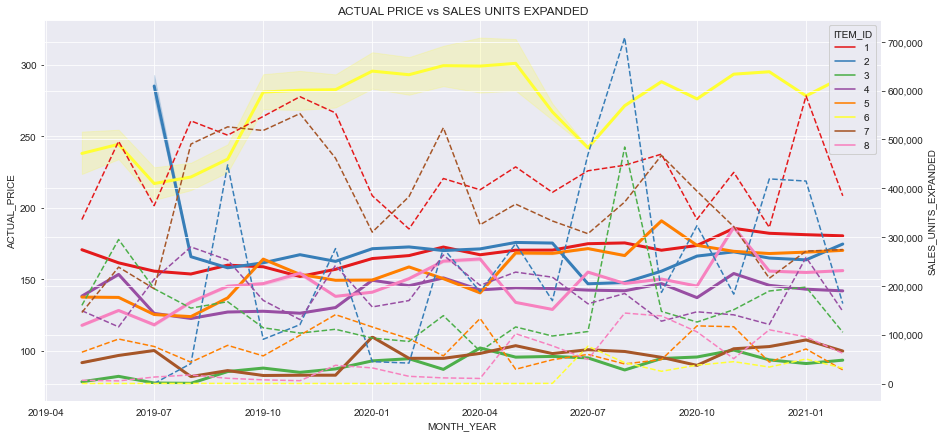

In [33]:
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))

fig, ax1 = plt.subplots(figsize=(15, 7))

ax1 = sns.lineplot(data=df1, x='MONTH_YEAR', y='ACTUAL_PRICE', palette='Set1', hue='ITEM_ID', linewidth=3)

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=sales_data, x='MONTH_YEAR', y='SALES_UNITS_EXPANDED', palette='Set1', hue='ITEM_ID', linestyle='dashed')
ax2.yaxis.set_major_formatter(formatter)

plt.title('ACTUAL PRICE vs SALES UNITS EXPANDED')
plt.show()

* Замечаете ли вы сезонные паттерны? Они похожи для всех товаров?
* Можно ли сделать вывод, что снижение цены приводит к увеличению продаж по этому графику? Почему да/нет? Теперь постройте второй график с SALES UNITS EXPADED и количеством магазинов с PERIOD ID на оси х. Подтверждает ли это ваше предыдущее заключение?

**Ответ:** </br>
На данном графие сложно выделить сезонные паттерны для всех товаров, так как они сильно различаются. Цена для item_id = 1 и item_id = 3 как будто не подлежат сезонному воздействию со слабо возрастающим трендом; цена для item_id = 6 из года в год сильно падает в Июле; цена для item_id = 5 возрастает ближе к Октябрю; ценя для item_id = 7 возрастает к Новому Году, но последний раз с меньшим эффектом; цена для item_id = 2 резко падает в Июле. Сезонные паттерны можно выделить для item_id = 8: цена возрастает в Ноябре и падает к Новому Году. </br>
Можно действительно предположить, что рост продаж в Июле 2020 - ого item_id = 6 сильно повлияло на снижение цены, а взрывной рост цены для item_id = 2 и item_id = 3 повлияло на небольшое снижение продаж за тот же период. Но эта зависимость не соблюдается на всём пути наблюдения, разве что для item_id = 5 она является справедливой.

In [30]:
shops_data = df1.groupby(['MONTH_YEAR', 'ITEM_ID'])['STORE_ID'].nunique().reset_index()
shops_data.head(3)

,MONTH_YEAR,ITEM_ID,STORE_ID
0,2019-05-01,1,24812
1,2019-05-01,3,22901
2,2019-05-01,4,18332


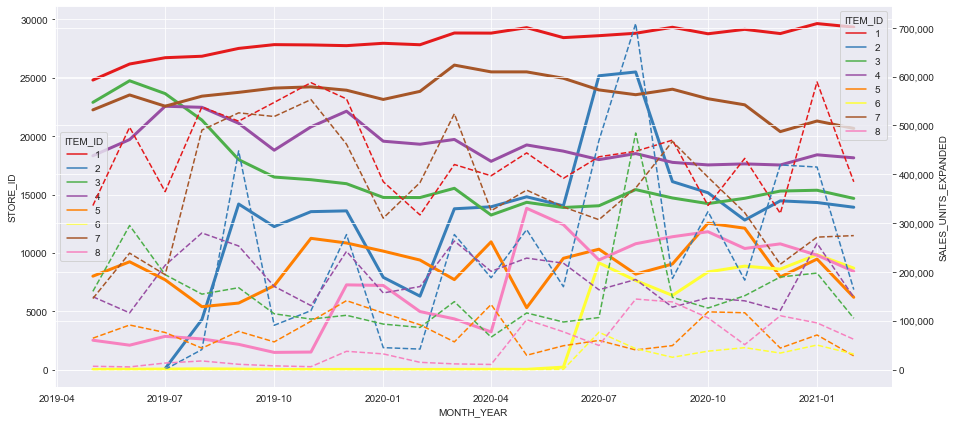

In [34]:
fig, ax1 = plt.subplots(figsize=(15, 7))

ax1 = sns.lineplot(data=shops_data, x='MONTH_YEAR', y='STORE_ID', palette='Set1', hue='ITEM_ID', linewidth=3)

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=sales_data, x='MONTH_YEAR', y='SALES_UNITS_EXPANDED', palette='Set1', hue='ITEM_ID', linestyle='dashed')
ax2.yaxis.set_major_formatter(formatter)

plt.show()

**Ответ:** </br>
Количество магазинов, в целом, сильно влияет на количество продаж: отклики на изменение количества магазинов так или иначе можно отметить для каждого item_id.

In [6]:
df1.head(3)

,ITEM_ID,ITEM_DESCRIPTION,CHANNEL,STORE_ID,PERIOD_ID,SALES_UNITS_EXPANDED,SALES_VOLUME_EXPANDED,SALES_VALUE_EXPANDED,ACTUAL_PRICE,MONTH,MONTH_YEAR
1876523,1,001_Item,TOTAL_MARKET,21656,2019-05-12,4.00,4.00,1049.37,262.34,5,2019-05-01
3509295,3,003_Item,TOTAL_MARKET,11432,2019-05-12,5.00,0.25,399.95,79.99,5,2019-05-01
7018897,7,007_Item,TOTAL_MARKET,22066,2019-05-12,8.00,0.40,638.42,79.80,5,2019-05-01


In [9]:
#ЦЕНОВАЯ АКЦИЯ = СНИЖЕНИЕ НА ОПРЕДЕЛЁННЫЙ ПРОЦЕНТ
df1 = df1.sort_values('PERIOD_ID')

df1['MIN_PRICE'] = df1.groupby(['PERIOD_ID', 'ITEM_ID'])['ACTUAL_PRICE'].transform('min')
df1['MEAN_PRICE'] = df1.groupby(['PERIOD_ID', 'ITEM_ID'])['ACTUAL_PRICE'].transform('mean')
df1['PRICE_WEEK_AGO'] = df1.groupby(['ITEM_ID', 'STORE_ID'])['ACTUAL_PRICE'].shift() #pct_change, diff

df1.head(3)

,ITEM_ID,ITEM_DESCRIPTION,CHANNEL,STORE_ID,PERIOD_ID,SALES_UNITS_EXPANDED,SALES_VOLUME_EXPANDED,SALES_VALUE_EXPANDED,ACTUAL_PRICE,MONTH,MONTH_YEAR,MIN_PRICE,MEAN_PRICE,PRICE_WEEK_AGO
1876523,1,001_Item,TOTAL_MARKET,21656,2019-05-12,4.00,4.00,1049.37,262.34,5,2019-05-01,0.00,219.39,NaN
7031303,7,007_Item,TOTAL_MARKET,22249,2019-05-12,9.00,0.45,718.72,79.86,5,2019-05-01,0.00,89.44,NaN
6020718,7,007_Item,TOTAL_MARKET,6470,2019-05-12,1.00,0.05,89.90,89.90,5,2019-05-01,0.00,89.44,NaN


Чтобы создать бинарную переменную PROMO, я бы смотрел на разницу между ACTUAL_PRICE между средней и минимальной ценой во всех магазинах. Также наличие PROMO должно влиять на резкое изменение цены по сравнению с ценой на прошлой неделе в том же магазине. Цена без промо должна быть связана со средней ценой, может даже совсем немного отличаться от неё.

6. Обсудите разницу между вашим подходом/ответами и новыми данными.

In [14]:
df2 = pd.read_csv('./df2.csv')
df2.head(3)

,ITEM_ID,STORE_ID,PERIOD_ID,PROMOTION_PRICE_INDEX,REGULAR_PRICE,PROMO
0,1,31905,70,0.91,219.90,0
1,1,31905,71,0.91,219.90,0
2,1,31905,72,0.91,219.90,0


In [16]:
df2[['PERIOD_ID', 'ACTUAL_PRICE']] = df1[['PERIOD_ID', 'ACTUAL_PRICE']]
df2 = df2.sort_values('PERIOD_ID')

#Средняя цена в определённую неделю для определённого item во всех магазинах
df2['MEAN_PRICE'] = df2.groupby(['PERIOD_ID', 'ITEM_ID'])['ACTUAL_PRICE'].transform('mean')
#Цена на прошлой неделе для определённого item в определённом store
df2['PRICE_WEEK_AGO'] = df2.groupby(['ITEM_ID', 'STORE_ID'])['ACTUAL_PRICE'].pct_change()

df2.head(3)

,ITEM_ID,STORE_ID,PERIOD_ID,PROMOTION_PRICE_INDEX,REGULAR_PRICE,PROMO,ACTUAL_PRICE,MEAN_PRICE,PRICE_WEEK_AGO
1876523,1,21656,2019-05-12,0.84,311.78,0,262.34,219.39,NaN
3509295,3,11432,2019-05-12,1.00,79.99,1,79.99,75.47,NaN
7018897,7,22066,2019-05-12,0.58,136.48,0,79.80,89.44,NaN


<AxesSubplot:xlabel='PROMO', ylabel='ACTUAL_PRICE'>

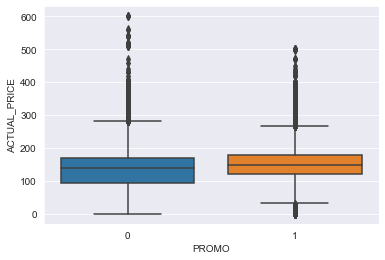

In [23]:
sns.boxplot(data = df2, y = 'ACTUAL_PRICE', x = 'PROMO')

Факт проведения PROMO уменьшает максимальную цену экстремальных значений цены. </br>
Распределение сужается вокруг медианы.

7. Перечислите и примените стандартные методы предварительной обработки данных перед переходом к этапу моделирования.
* Подсказка: начните с определения и обработки выбросов, а затем используйте соответствующие инструменты для исправления возможных проблем, которые могут возникнуть с данными о ценах на продажи.

**Стандартными методами предобработки данных являются:**
* Использование численных признаков, предварительное кодирование категориальных признаков
* Поиск и удаление дубликатов в данных
* Обработка пропусков в данных
* Предварительная визуализация данных, позволяющая отловить возможную немонотонность, нелинейность и прерывность зависимости предикатов и прогнозируемой переменной
* Логарифимическая (или другая) трансформация данных, потенциально позволяющая избавиться как от нелинейности зависимости, так и от проблемы ненормального распределения данных и гетероскедатичности остатков
* Анализ данных на мультиколлинеарность
* Масштабирование данных

In [44]:
data = df1[['ITEM_ID', 'STORE_ID', 'SALES_UNITS_EXPANDED', 'SALES_VALUE_EXPANDED', 'MONTH', 'ACTUAL_PRICE']]
data[['PROMOTION_PRICE_INDEX', 'REGULAR_PRICE', 'PROMO']] = df2[['PROMOTION_PRICE_INDEX', 'REGULAR_PRICE', 'PROMO']]
data.head(3)

,ITEM_ID,STORE_ID,SALES_UNITS_EXPANDED,SALES_VALUE_EXPANDED,MONTH,ACTUAL_PRICE,PROMOTION_PRICE_INDEX,REGULAR_PRICE,PROMO
0,1,31905,1.00,199.90,7,199.90,0.91,219.90,0
1,1,31905,3.00,599.70,7,199.90,0.91,219.90,0
2,1,31905,1.00,199.90,7,199.90,0.91,219.90,0


Для проверки данных на дубликаты необходимо будет вернуть столбцей с PERIOD_ID, так как дата является уникальным идентификатором продажи SKU.

In [49]:
data['PERIOD_ID'] = df1['PERIOD_ID']
data[data.duplicated()]

,ITEM_ID,STORE_ID,SALES_UNITS_EXPANDED,SALES_VALUE_EXPANDED,MONTH,ACTUAL_PRICE,PROMOTION_PRICE_INDEX,REGULAR_PRICE,PROMO,PERIOD_ID


Убедившись, что дубликатов нет, удалим из датасета признак PERIOD_ID и проверим данные на пропуски.

In [53]:
data.drop(labels=['PERIOD_ID'], axis=1, inplace=True)

cols_null_percent = data.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

Series([], dtype: float64)

Пропусков в данных нет.

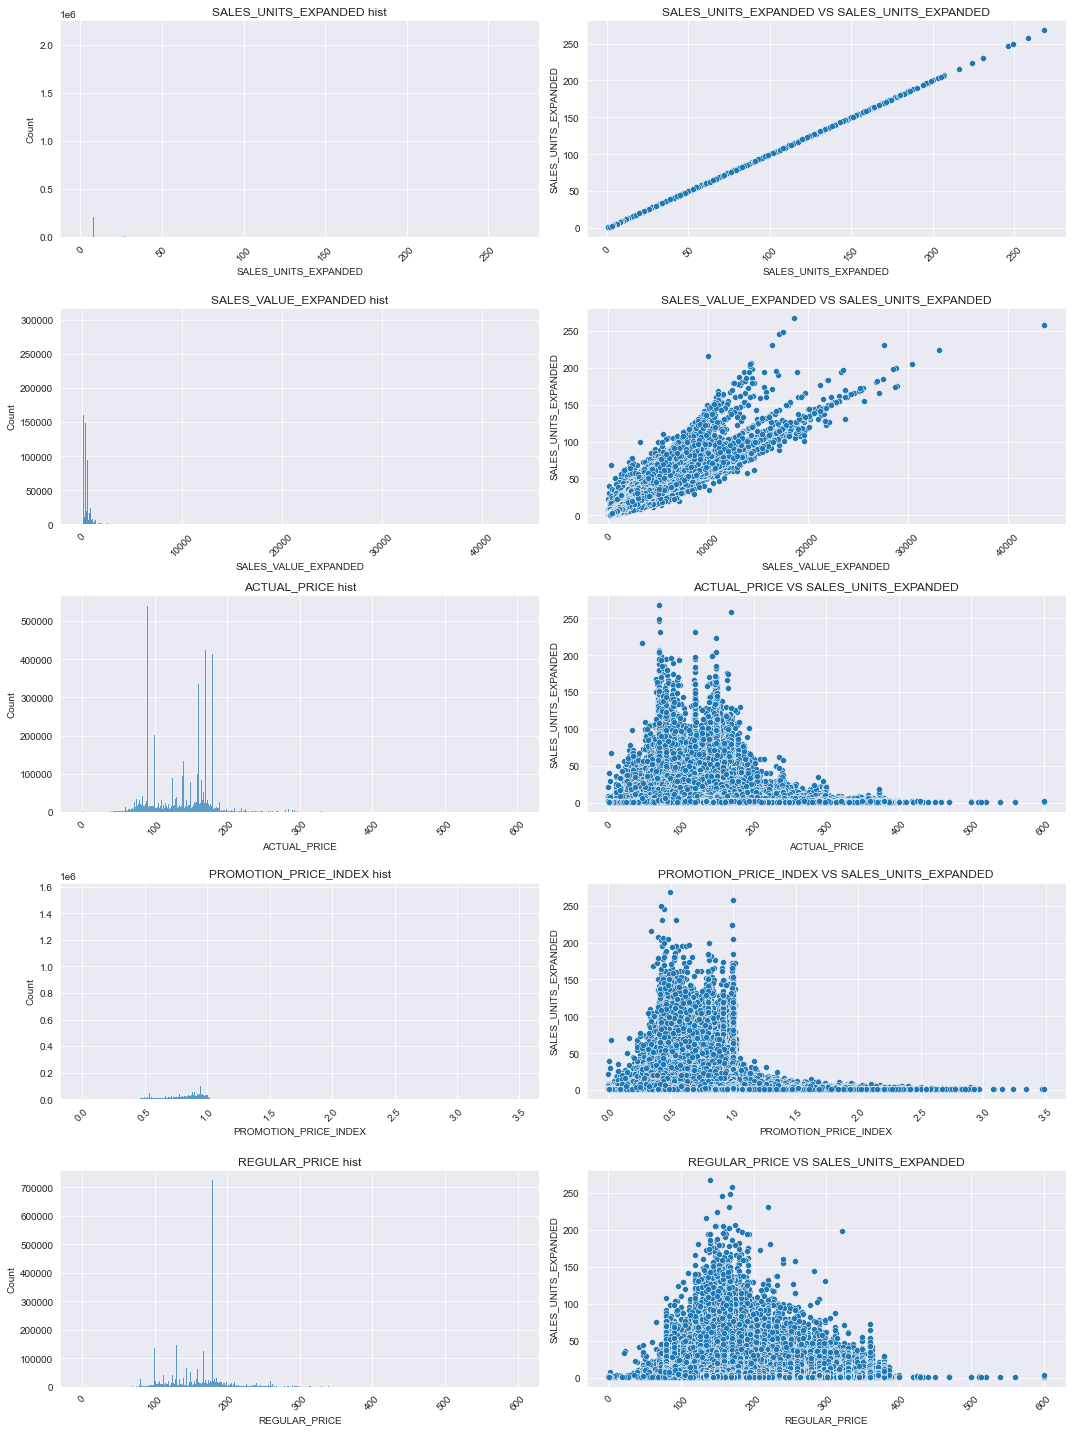

In [56]:
num_features = ['SALES_UNITS_EXPANDED', 'SALES_VALUE_EXPANDED', 'ACTUAL_PRICE', 'PROMOTION_PRICE_INDEX', 'REGULAR_PRICE']
n = len(num_features) #количество числовых признаков

fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    scatterplot = sns.scatterplot(data=data, x=feature, y='SALES_UNITS_EXPANDED', ax=axes[i][1])
    #Добавляем подпись графику
    scatterplot.set_title('{} VS SALES_UNITS_EXPANDED'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    scatterplot.xaxis.set_tick_params(rotation=45)
    
plt.tight_layout() #выравнивание графиков

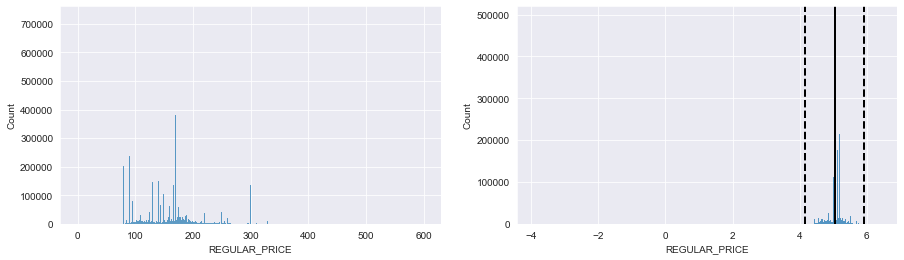

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=data, x='REGULAR_PRICE', ax=axes[0]);
#Логарифмируем
log_price = np.log(data['REGULAR_PRICE'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

CPU times: total: 0 ns
Wall time: 38.9 ms


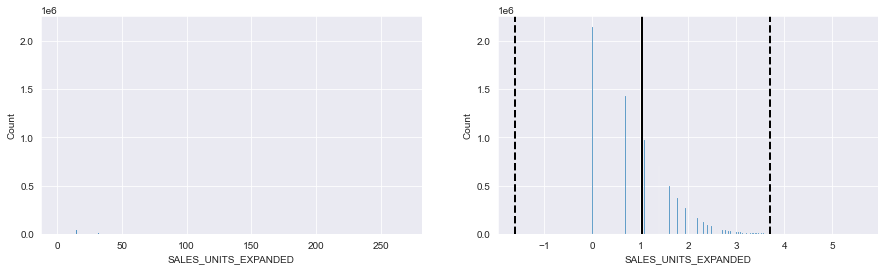

In [58]:
%time

fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=data, x='SALES_UNITS_EXPANDED', ax=axes[0]);
#Логарифмируем
log_price = np.log(data['SALES_UNITS_EXPANDED'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

CPU times: total: 0 ns
Wall time: 70.3 ms


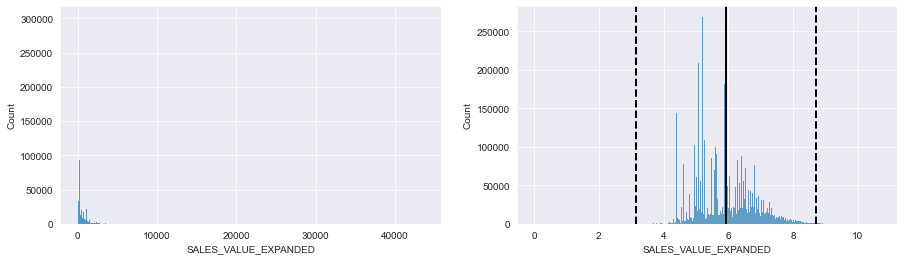

In [60]:
%time

fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=data, x='SALES_VALUE_EXPANDED', ax=axes[0]);
#Логарифмируем
log_price = np.log(data['SALES_VALUE_EXPANDED'] + 1)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

CPU times: total: 0 ns
Wall time: 0 ns


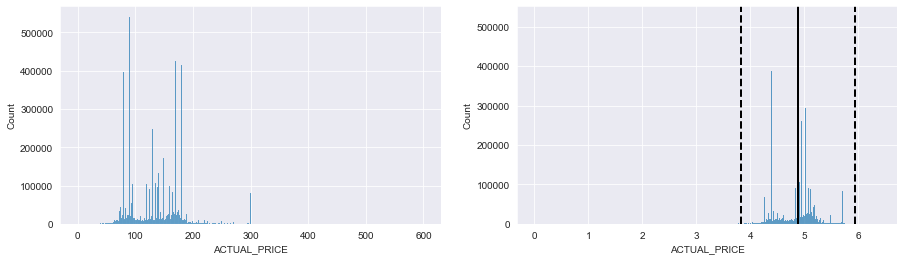

In [62]:
%time

fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=data, x='ACTUAL_PRICE', ax=axes[0]);
#Логарифмируем
log_price = np.log(data['ACTUAL_PRICE'] + 1)
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

In [63]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
#Производим очистку 
outliers, data = outliers_z_score(data, 'REGULAR_PRICE', log_scale=True)
outliers, data = outliers_z_score(data, 'ACTUAL_PRICE', log_scale=True)
outliers, data = outliers_z_score(data, 'SALES_VALUE_EXPANDED', log_scale=True)
outliers, data = outliers_z_score(data, 'SALES_UNITS_EXPANDED', log_scale=True)

In [66]:
from sklearn.preprocessing import MinMaxScaler

#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(data)
data_scaled = scaler.transform(data)

## Modeling Exercise

List necessary and sufficient assumption to get consistent and asymptotically normal estimate of the marginal
impact of price parameters on sales using OLS?
* Do we require normality of errors to obtain consistent estimate?
* How does violating spherical errors impact consistency of the estimate? </br>

**Ответ:** </br>
Для использования модели OLS для прогнозирования продаж необходимыми и достаточными условиями являются:
* Линейная зависимость зависимой переменной от предикторов
* Нормальное распределение остатков и их гомоскедатичность
* Отсутствие сильной коллинеарности между предикторами

In [14]:
import statsmodels.api as sm

df2['ITEM_ID'] = df1['ITEM_ID']

Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    17.66
REGULAR_PRICE            -0.01
PROMO                    -1.59
PROMOTION_PRICE_INDEX   -11.94
dtype: float64

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.068
Model:                              OLS   Adj. R-squared:                  0.068
Method:                   Least Squares   F-statistic:                 5.045e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:49:36   Log-Likelihood:            -6.3958e+06
No. Observations:               2068418   AIC:                         1.279e+07
Df Residuals:                   2068414   BIC:                         1.279e+07
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    17.6621      0.060    293.778      0.000      17.544      17.780
REGULAR_PRICE            -0.0100      0.000    -48.599      0.000      -0.010      -0.010
PROMO                    -1.5897      0.012   -128.460      0.000      -1.614      -1.565
PROMOTION_PRICE_INDEX   -11.9375      0.038   -310.570      0.000     -12.013     -11.862
==============================================================================
Omnibus:                  2046472.438   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        192243453.083
Skew:                           4.688   Prob(JB):                         0.00
Kurtosis:                      49.289   Cond. No.                     3.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    30.21
REGULAR_PRICE            -0.04
PROMO                    -1.90
PROMOTION_PRICE_INDEX   -18.27
dtype: float64

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.054
Model:                              OLS   Adj. R-squared:                  0.054
Method:                   Least Squares   F-statistic:                 1.488e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:52:17   Log-Likelihood:            -2.6809e+06
No. Observations:                781854   AIC:                         5.362e+06
Df Residuals:                    781850   BIC:                         5.362e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    30.2114      0.159    190.125      0.000      29.900      30.523
REGULAR_PRICE            -0.0379      0.001    -74.418      0.000      -0.039      -0.037
PROMO                    -1.8971      0.025    -76.509      0.000      -1.946      -1.849
PROMOTION_PRICE_INDEX   -18.2717      0.119   -153.829      0.000     -18.504     -18.039
==============================================================================
Omnibus:                   687818.693   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40614863.516
Skew:                           4.002   Prob(JB):                         0.00
Kurtosis:                      37.390   Cond. No.                     3.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 3].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 3].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    7.40
REGULAR_PRICE           -0.01
PROMO                   -0.95
PROMOTION_PRICE_INDEX   -3.42
dtype: float64

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.028
Model:                              OLS   Adj. R-squared:                  0.028
Method:                   Least Squares   F-statistic:                     9680.
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:53:07   Log-Likelihood:            -2.8138e+06
No. Observations:                997277   AIC:                         5.628e+06
Df Residuals:                    997273   BIC:                         5.628e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.3994      0.048    153.245      0.000       7.305       7.494
REGULAR_PRICE            -0.0079      0.000    -31.737      0.000      -0.008      -0.007
PROMO                    -0.9516      0.011    -83.732      0.000      -0.974      -0.929
PROMOTION_PRICE_INDEX    -3.4199      0.035    -96.722      0.000      -3.489      -3.351
==============================================================================
Omnibus:                  1086707.151   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        162981285.367
Skew:                           5.367   Prob(JB):                         0.00
Kurtosis:                      64.701   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    9.17
REGULAR_PRICE           -0.01
PROMO                   -1.36
PROMOTION_PRICE_INDEX   -4.30
dtype: float64

In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.036
Model:                              OLS   Adj. R-squared:                  0.036
Method:                   Least Squares   F-statistic:                 1.353e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:53:37   Log-Likelihood:            -3.2028e+06
No. Observations:               1082849   AIC:                         6.406e+06
Df Residuals:                   1082845   BIC:                         6.406e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.1729      0.046    200.154      0.000       9.083       9.263
REGULAR_PRICE            -0.0096      0.000    -70.033      0.000      -0.010      -0.009
PROMO                    -1.3620      0.015    -92.436      0.000      -1.391      -1.333
PROMOTION_PRICE_INDEX    -4.2988      0.032   -132.350      0.000      -4.362      -4.235
==============================================================================
Omnibus:                  1342588.732   Durbin-Watson:                   1.574
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        465872532.333
Skew:                           6.464   Prob(JB):                         0.00
Kurtosis:                     103.789   Cond. No.                     2.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 5].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 5].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                   11.25
REGULAR_PRICE           -0.02
PROMO                   -0.86
PROMOTION_PRICE_INDEX   -4.63
dtype: float64

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.067
Model:                              OLS   Adj. R-squared:                  0.067
Method:                   Least Squares   F-statistic:                 1.200e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:54:46   Log-Likelihood:            -1.2651e+06
No. Observations:                498226   AIC:                         2.530e+06
Df Residuals:                    498222   BIC:                         2.530e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.2526      0.050    225.857      0.000      11.155      11.350
REGULAR_PRICE            -0.0195      0.000   -136.675      0.000      -0.020      -0.019
PROMO                    -0.8587      0.010    -84.313      0.000      -0.879      -0.839
PROMOTION_PRICE_INDEX    -4.6303      0.038   -122.960      0.000      -4.704      -4.556
==============================================================================
Omnibus:                   438666.526   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32259181.123
Skew:                           3.920   Prob(JB):                         0.00
Kurtosis:                      41.633   Cond. No.                     2.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 6].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 6].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    6.17
REGULAR_PRICE           -0.00
PROMO                   -0.86
PROMOTION_PRICE_INDEX   -2.93
dtype: float64

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.056
Model:                              OLS   Adj. R-squared:                  0.056
Method:                   Least Squares   F-statistic:                     3167.
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:55:12   Log-Likelihood:            -3.3214e+05
No. Observations:                159556   AIC:                         6.643e+05
Df Residuals:                    159552   BIC:                         6.643e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.1716      0.105     58.986      0.000       5.966       6.377
REGULAR_PRICE            -0.0039      0.000    -12.320      0.000      -0.004      -0.003
PROMO                    -0.8590      0.015    -58.760      0.000      -0.888      -0.830
PROMOTION_PRICE_INDEX    -2.9326      0.047    -62.608      0.000      -3.024      -2.841
==============================================================================
Omnibus:                   144135.450   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10149377.955
Skew:                           4.111   Prob(JB):                         0.00
Kurtosis:                      41.198   Cond. No.                     6.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 7].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 7].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                   12.04
REGULAR_PRICE            0.00
PROMO                   -0.88
PROMOTION_PRICE_INDEX   -9.21
dtype: float64

In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.098
Model:                              OLS   Adj. R-squared:                  0.098
Method:                   Least Squares   F-statistic:                 5.704e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:55:39   Log-Likelihood:            -5.1955e+06
No. Observations:               1577807   AIC:                         1.039e+07
Df Residuals:                   1577803   BIC:                         1.039e+07
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.0433      0.044    275.497      0.000      11.958      12.129
REGULAR_PRICE          9.831e-05      0.000      0.510      0.610      -0.000       0.000
PROMO                    -0.8827      0.019    -47.016      0.000      -0.920      -0.846
PROMOTION_PRICE_INDEX    -9.2068      0.031   -292.855      0.000      -9.268      -9.145
==============================================================================
Omnibus:                  1803423.050   Durbin-Watson:                   1.390
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        332148313.297
Skew:                           5.777   Prob(JB):                         0.00
Kurtosis:                      73.134   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    6.51
REGULAR_PRICE           -0.00
PROMO                   -1.46
PROMOTION_PRICE_INDEX   -2.72
dtype: float64

In [31]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.065
Model:                              OLS   Adj. R-squared:                  0.065
Method:                   Least Squares   F-statistic:                     7747.
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          21:56:19   Log-Likelihood:            -8.8495e+05
No. Observations:                334198   AIC:                         1.770e+06
Df Residuals:                    334194   BIC:                         1.770e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.5129      0.048    135.617      0.000       6.419       6.607
REGULAR_PRICE            -0.0029      0.000    -22.591      0.000      -0.003      -0.003
PROMO                    -1.4609      0.015    -96.061      0.000      -1.491      -1.431
PROMOTION_PRICE_INDEX    -2.7196      0.036    -76.604      0.000      -2.789      -2.650
==============================================================================
Omnibus:                   294141.718   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         36167612.342
Skew:                           3.725   Prob(JB):                         0.00
Kurtosis:                      53.416   Cond. No.                     1.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* How does the coefficient interpretation change from the model in 
* Perform t-test and F-test. What can we infer from this? Are these test values accurate?
* Which model do you think is more realistic? Explain.

**Ответ:** </br>
На вопрос про реалистичность модели сложно ответить, так как результаты модели после логарифмического преобразованию также поддаются интерпретации. В таких моделях весовой коэффициент показывает, на сколько процентов увеличится (или уменьшится, в зависимости от знака) значение зависимой переменной при условии, что значение независимой переменной увеличится на 1%

In [39]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 1]
x_log.drop(labels=['ITEM_ID'], axis=1, inplace=True)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [40]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

const                    4.39
REGULAR_PRICE           -0.29
PROMO                   -0.51
PROMOTION_PRICE_INDEX   -2.09
dtype: float64

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.075
Model:                              OLS   Adj. R-squared:                  0.075
Method:                   Least Squares   F-statistic:                 5.590e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:09:03   Log-Likelihood:            -1.9951e+06
No. Observations:               2068418   AIC:                         3.990e+06
Df Residuals:                   2068414   BIC:                         3.990e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.3857      0.028    154.646      0.000       4.330       4.441
REGULAR_PRICE            -0.2887      0.005    -57.652      0.000      -0.298      -0.279
PROMO                    -0.5098      0.002   -240.639      0.000      -0.514      -0.506
PROMOTION_PRICE_INDEX    -2.0915      0.008   -254.139      0.000      -2.108      -2.075
==============================================================================
Omnibus:                   103729.761   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119970.198
Skew:                           0.582   Prob(JB):                         0.00
Kurtosis:                       3.187   Cond. No.                         353.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 2]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [46]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

ITEM_ID                  4.22
REGULAR_PRICE           -0.88
PROMO                   -0.43
PROMOTION_PRICE_INDEX   -3.31
dtype: float64

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.074
Model:                              OLS   Adj. R-squared:                  0.074
Method:                   Least Squares   F-statistic:                 2.087e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:09:32   Log-Likelihood:            -8.7060e+05
No. Observations:                781854   AIC:                         1.741e+06
Df Residuals:                    781850   BIC:                         1.741e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   4.2185      0.024    173.010      0.000       4.171       4.266
REGULAR_PRICE            -0.8844      0.008   -105.420      0.000      -0.901      -0.868
PROMO                    -0.4274      0.004   -121.602      0.000      -0.434      -0.420
PROMOTION_PRICE_INDEX    -3.3126      0.022   -153.602      0.000      -3.355      -3.270
==============================================================================
Omnibus:                    30761.989   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34550.331
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                       2.958   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 3].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 3]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [49]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

ITEM_ID                  0.70
REGULAR_PRICE           -0.08
PROMO                   -0.28
PROMOTION_PRICE_INDEX   -0.72
dtype: float64

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.034
Model:                              OLS   Adj. R-squared:                  0.034
Method:                   Least Squares   F-statistic:                 1.171e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:10:15   Log-Likelihood:            -8.7824e+05
No. Observations:                997277   AIC:                         1.756e+06
Df Residuals:                    997273   BIC:                         1.757e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   0.7045      0.007    100.641      0.000       0.691       0.718
REGULAR_PRICE            -0.0776      0.004    -20.392      0.000      -0.085      -0.070
PROMO                    -0.2805      0.002   -119.341      0.000      -0.285      -0.276
PROMOTION_PRICE_INDEX    -0.7190      0.009    -77.276      0.000      -0.737      -0.701
==============================================================================
Omnibus:                   129077.585   Durbin-Watson:                   1.409
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188395.327
Skew:                           0.977   Prob(JB):                         0.00
Kurtosis:                       3.845   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 4]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [52]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

ITEM_ID                  0.94
REGULAR_PRICE           -0.32
PROMO                   -0.39
PROMOTION_PRICE_INDEX   -1.25
dtype: float64

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.061
Model:                              OLS   Adj. R-squared:                  0.061
Method:                   Least Squares   F-statistic:                 2.327e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:10:49   Log-Likelihood:            -1.0016e+06
No. Observations:               1082849   AIC:                         2.003e+06
Df Residuals:                   1082845   BIC:                         2.003e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   0.9399      0.005    183.319      0.000       0.930       0.950
REGULAR_PRICE            -0.3235      0.003    -96.991      0.000      -0.330      -0.317
PROMO                    -0.3897      0.003   -139.831      0.000      -0.395      -0.384
PROMOTION_PRICE_INDEX    -1.2450      0.008   -158.864      0.000      -1.260      -1.230
==============================================================================
Omnibus:                   116269.646   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           158967.364
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                       3.669   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 5].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 5]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [55]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

ITEM_ID                  1.18
REGULAR_PRICE           -0.70
PROMO                   -0.25
PROMOTION_PRICE_INDEX   -1.50
dtype: float64

In [56]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.076
Model:                              OLS   Adj. R-squared:                  0.076
Method:                   Least Squares   F-statistic:                 1.361e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:11:26   Log-Likelihood:            -3.8877e+05
No. Observations:                498226   AIC:                         7.775e+05
Df Residuals:                    498222   BIC:                         7.776e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   1.1840      0.006    207.896      0.000       1.173       1.195
REGULAR_PRICE            -0.6995      0.005   -147.994      0.000      -0.709      -0.690
PROMO                    -0.2546      0.003    -99.533      0.000      -0.260      -0.250
PROMOTION_PRICE_INDEX    -1.4965      0.012   -121.998      0.000      -1.521      -1.472
==============================================================================
Omnibus:                    23861.252   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27470.537
Skew:                           0.574   Prob(JB):                         0.00
Kurtosis:                       3.066   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 6].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 6]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [58]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

ITEM_ID                  0.46
REGULAR_PRICE           -0.18
PROMO                   -0.37
PROMOTION_PRICE_INDEX   -1.03
dtype: float64

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.071
Model:                              OLS   Adj. R-squared:                  0.071
Method:                   Least Squares   F-statistic:                     4092.
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:12:24   Log-Likelihood:                -88119.
No. Observations:                159556   AIC:                         1.762e+05
Df Residuals:                    159552   BIC:                         1.763e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   0.4637      0.015     31.733      0.000       0.435       0.492
REGULAR_PRICE            -0.1819      0.015    -11.971      0.000      -0.212      -0.152
PROMO                    -0.3671      0.005    -80.513      0.000      -0.376      -0.358
PROMOTION_PRICE_INDEX    -1.0297      0.018    -57.132      0.000      -1.065      -0.994
==============================================================================
Omnibus:                    30712.875   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56639.777
Skew:                           1.210   Prob(JB):                         0.00
Kurtosis:                       4.631   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 7].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 7]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [61]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()
results.params

ITEM_ID                  0.51
REGULAR_PRICE           -0.18
PROMO                   -0.34
PROMOTION_PRICE_INDEX   -2.19
dtype: float64

In [62]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.156
Model:                              OLS   Adj. R-squared:                  0.156
Method:                   Least Squares   F-statistic:                 9.726e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:13:23   Log-Likelihood:            -1.5770e+06
No. Observations:               1577807   AIC:                         3.154e+06
Df Residuals:                   1577803   BIC:                         3.154e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   0.5123      0.002    247.286      0.000       0.508       0.516
REGULAR_PRICE            -0.1779      0.003    -69.670      0.000      -0.183      -0.173
PROMO                    -0.3375      0.003   -123.648      0.000      -0.343      -0.332
PROMOTION_PRICE_INDEX    -2.1867      0.006   -386.881      0.000      -2.198      -2.176
==============================================================================
Omnibus:                    79638.566   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            92715.459
Skew:                           0.568   Prob(JB):                         0.00
Kurtosis:                       3.345   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
y_log = np.log(df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1) + 1)
x_log = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df1['ITEM_ID'] == 8]
x_log.drop(labels=['ITEM_ID'], axis=1)
x_log['REGULAR_PRICE'] = np.log(df2['REGULAR_PRICE'] + 1)
x_log['PROMO'] = np.log(df2['PROMO'] + 1)
x_log['PROMOTION_PRICE_INDEX'] = np.log(df2['PROMOTION_PRICE_INDEX'] + 1)

In [66]:
Y = y_log
X = x_log
X = sm.add_constant(x_log)

model = sm.OLS(Y, X)
results = model.fit()

In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     SALES_UNITS_EXPANDED   R-squared:                       0.092
Model:                              OLS   Adj. R-squared:                  0.092
Method:                   Least Squares   F-statistic:                 1.126e+04
Date:                  Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                          22:13:53   Log-Likelihood:            -2.8178e+05
No. Observations:                334198   AIC:                         5.636e+05
Df Residuals:                    334194   BIC:                         5.636e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ITEM_ID                   0.3971      0.004    108.972      0.000       0.390       0.404
REGULAR_PRICE            -0.2329      0.005    -49.224      0.000      -0.242      -0.224
PROMO                    -0.4328      0.004   -119.165      0.000      -0.440      -0.426
PROMOTION_PRICE_INDEX    -1.0613      0.011    -94.437      0.000      -1.083      -1.039
==============================================================================
Omnibus:                    27877.017   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35358.599
Skew:                           0.785   Prob(JB):                         0.00
Kurtosis:                       3.268   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Perform OLS under these assumptions and obtain the coefficients for each item. How does the estimate change
from the before? What does it say about our data?

In [68]:
df1.head(3)

,ITEM_ID,ITEM_DESCRIPTION,CHANNEL,STORE_ID,PERIOD_ID,SALES_UNITS_EXPANDED,SALES_VOLUME_EXPANDED,SALES_VALUE_EXPANDED
0,1,001_Item,TOTAL_MARKET,31905,70,1,1.00,199.90
1,1,001_Item,TOTAL_MARKET,31905,71,3,3.00,599.70
2,1,001_Item,TOTAL_MARKET,31905,72,1,1.00,199.90


In [71]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.MixedLM(Y, X, groups=df1[['ITEM_ID', 'STORE_ID']][df1['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1),
                   exog_re=df1[['ITEM_ID', 'PERIOD_ID']][df1['ITEM_ID'] == 1].drop(labels=['ITEM_ID'], axis=1))
results = model.fit()
results.summary()

LinAlgError: Singular matrix

In [72]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.MixedLM(Y, X, groups=df1[['ITEM_ID', 'STORE_ID']][df1['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1),
                   exog_re=df1[['ITEM_ID', 'PERIOD_ID']][df1['ITEM_ID'] == 2].drop(labels=['ITEM_ID'], axis=1))
results = model.fit()
results.summary()

LinAlgError: Singular matrix

In [73]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.MixedLM(Y, X, groups=df1[['ITEM_ID', 'STORE_ID']][df1['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1),
                   exog_re=df1[['ITEM_ID', 'PERIOD_ID']][df1['ITEM_ID'] == 4].drop(labels=['ITEM_ID'], axis=1))
results = model.fit()
results.summary()

LinAlgError: Singular matrix

In [74]:
Y = df1[['ITEM_ID', 'SALES_UNITS_EXPANDED']][df1['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1)
X = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX']][df2['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1)
X = sm.add_constant(X)

model = sm.MixedLM(Y, X, groups=df1[['ITEM_ID', 'STORE_ID']][df1['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1),
                   exog_re=df1[['ITEM_ID', 'PERIOD_ID']][df1['ITEM_ID'] == 8].drop(labels=['ITEM_ID'], axis=1))
results = model.fit()
results.summary()

LinAlgError: Singular matrix

Lastly, we want to test the impact of each item on each other. To do this, in addition to own independent variables from a
given item, we need to add to our xit values from competitor items. So for example, a model for 001 Item would include
its own REGULAR PRICE, PROMO and PROMOTION PRICE INDEX and then same values for each competitor.

In [116]:
df = df2[['ITEM_ID', 'REGULAR_PRICE', 'PROMO', 'PROMOTION_PRICE_INDEX', 'PERIOD_ID']]

price_pivot = df.pivot_table(index='PERIOD_ID', columns='ITEM_ID', values='REGULAR_PRICE')
promo_pivot = df.pivot_table(index='PERIOD_ID', columns='ITEM_ID', values='PROMO')
prindex_pivot = df.pivot_table(index='PERIOD_ID', columns='ITEM_ID', values='PROMOTION_PRICE_INDEX')

promo_pivot.rename(columns={1: 'RPR_1', 2: 'RPR_2', 3: 'RPR_3', 4: 'RPR_4',
                            5: 'RPR_5', 6: 'RPR_6', 7: 'RPR_7', 8: 'RPR_8'}, inplace = True)

promo_pivot.rename(columns={1: 'PROMO_1', 2: 'PROMO_2', 3: 'PROMO_3', 4: 'PROMO_4',
                            5: 'PROMO_5', 6: 'PROMO_6', 7: 'PROMO_7', 8: 'PROMO_8'}, inplace = True)

prindex_pivot.rename(columns={1: 'PP_1', 2: 'PP_2', 3: 'PP_3', 4: 'PP_4',
                              5: 'PP_5', 6: 'PP_6', 7: 'PP_7', 8: 'PP_8'}, inplace = True)

merged_df = df.merge(price_pivot, on=['PERIOD_ID'])

merged_df['RPR_1'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_1']
merged_df['RPR_2'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_2']
merged_df['RPR_3'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_3']
merged_df['RPR_4'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_4']
merged_df['RPR_5'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_5']
merged_df['RPR_6'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_6']
merged_df['RPR_7'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_7']
merged_df['RPR_8'] = merged_df['REGULAR_PRICE'] / merged_df['RPR_8']

merged_df.head(3)

,ITEM_ID,REGULAR_PRICE,PROMO,PROMOTION_PRICE_INDEX,PERIOD_ID,RPR_1,RPR_2,RPR_3,RPR_4,RPR_5,RPR_6,RPR_7,RPR_8
0,1,219.90,0,0.91,70,1.20,1.21,1.98,1.24,1.26,0.74,1.60,1.22
1,1,179.86,1,1.00,70,0.98,0.99,1.62,1.01,1.03,0.60,1.31,0.99
2,1,179.38,0,1.00,70,0.98,0.98,1.62,1.01,1.03,0.60,1.30,0.99
